对特征词进行加权，模型集成stacking，融合word2vec特征。

模型优点：
      
    1.stacking模型泛化能力更强，减少过拟合的可能性
    2.训练词向量的语料库同时使用了训练集和预测集，数据量更大。
    3.采用并行的方式提取特征（时间效率高）
    4.模型计算使用稀疏矩阵（空间占用少）

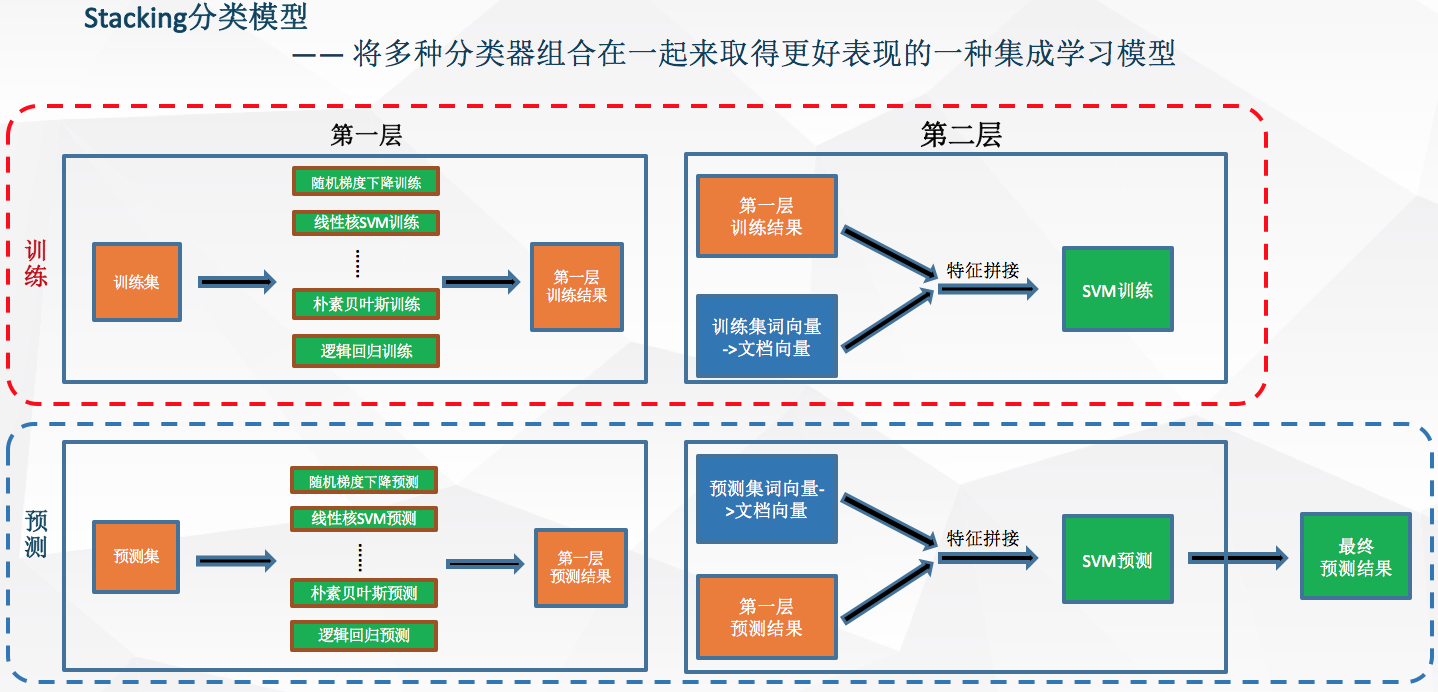

TF-IDF的改进：这种加权方法降低了语料库中同类型文本对词语权重的影响，更精确地表达了这个特征词对文档的重要程度。
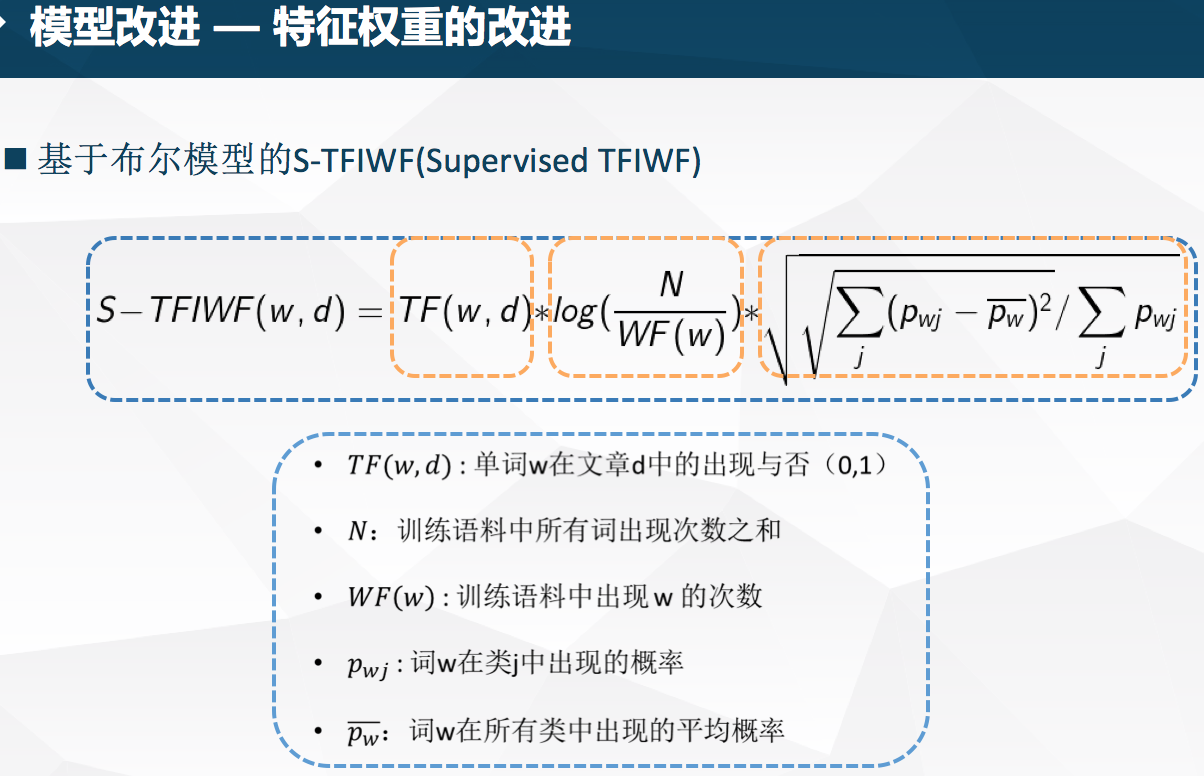

In [37]:
import time
import numpy as np
import multiprocessing
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier, LogisticRegression,RidgeClassifier,PassiveAggressiveClassifier,Lasso,HuberRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler

In [34]:
'''
t = [1,2,3,4,5]
kfold = KFold(n_splits=3, random_state=0)
len(list(kfold.split(t)))

random_rate = 2019
clf1 = LinearSVC(C=0.1, random_state=random_rate)
clf2 = LogisticRegression(C=1.0,n_jobs=-1, max_iter=100, class_weight='balanced', random_state=random_rate)
clf3 = BernoulliNB(alpha=0.1)
'''

"\nt = [1,2,3,4,5]\nkfold = KFold(n_splits=3, random_state=0)\nlen(list(kfold.split(t)))\n\nrandom_rate = 2019\nclf1 = LinearSVC(C=0.1, random_state=random_rate)\nclf2 = LogisticRegression(C=1.0,n_jobs=-1, max_iter=100, class_weight='balanced', random_state=random_rate)\nclf3 = BernoulliNB(alpha=0.1)\n"

In [39]:
class Stacking_model(object):
    def __init__(self):
        random_rate = 2019
        clf1 = LinearSVC(C=0.1, random_state=random_rate)
        clf2 = LogisticRegression(C=1.0,n_jobs=-1, max_iter=100, class_weight='balanced', random_state=random_rate)
        clf3 = BernoulliNB(alpha=0.1)
        # ... 这里可以采用更多的分类器
        base_models = [
            ['lsvc', clf1],
            ['lr', clf2],
            ['bnb', clf3]
        ]
        self.base_models = base_models
        self.LR = clf2
        self.svc = SVC(C=1,random_state=random_rate,cache_size=1000)
        
    def validation(self, X, Y, wv_X, kind):
        """
        2-fold validation
        """
        print('validating ', kind)
        st_time = time.time()
        
        fold_n = 2
        skf = StratifiedKFold(n_splits=fold_n)
        score = np.zeros(fold_n)
        for j, (train_idx, test_idx) in enumerate(skf.split(X, Y)):
            print(str(j+1)+'-fold')
            
            X_train = X[train_idx]
            y_train = Y[train_idx]
            X_test = X[test_idx]
            y_test = Y[test_idx]
            
            wv_X_train = wv_X[train_idx]
            wv_X_test = wv_X[test_idx]
            
            vectorizer = TfidfVectorizer(max_features = 5000)
            vectorizer.fit(X_train, y_train)
            X_train = vectorizer.transform(X_train)
            X_test = vectorizer.transform(X_test)
            print('shape: ', X_train.shape)
            
            # 输入分词数据，词嵌入向量数据，根据验证集数据进行预测
            y_pred = self.stacking(X_train, y_train, X_test, wv_X_train, wv_X_test, kind)
            cur_score = sum(y_test == y_pred) * 1.0 / len(y_pred)
            score[j] = cur_score
        print('验证',kind, ', 共耗时:', time.time()-st_time)
        print('score: ', score)
        print('mean_score, kind: ', score.mean(), kind)
        return score.mean()
        
    def stacking(self, X, Y, T, wv_X, wv_T, kind):
        """ 
        通过stacking进行ensemble model
        将分类器获取的概率值作为特征（第一层预测结果）和word2vec词向量特征进行拼接
        输入到svm中进行第二层的预测
        """
        models = self.base_models
        
        # 对训练数据集进行5折划分
        kfold = KFold(n_splits=5, random_state=0)
        folds = list(kfold.split(Y))
        
        features_train = np.zeros((X.shape[0], len(models)))
        features_test = np.zeros((T.shape[0], len(models)))
        
        # i代表第几种分类器
        for i, m in enumerate(models):
            clf = m[1]
            features_test_i = np.zeros((T.shape[0], len(folds)))
            for j, (train_idx, valid_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = Y[train_idx]
                X_valid = X[valid_idx]
                
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_valid)[:]
                features_train[valid_idx, i] = y_pred
                features_test_i[:, j] = clf.predict(T)[:]
            features_test[:, i] = features_test_i.mean(1)
        print('features_train.shape, features_test.shape: ', features_train.shape, features_test.shape)
        
        print('scalering...')
        features_train = np.concatenate((features_train, wv_X), axis=1)
        features_test = np.concatenate((features_test, wv_T), axis=1)
        print('features_train.shape, features_test.shape: ', features_train.shape, features_test.shape)

        min_max_scaler = StandardScaler()
        features_train = min_max_scaler.fit_transform(features_train)
        features_test = min_max_scaler.fit_transform(features_test)
        
        self.svc.fit(features_train, Y)
        y_pred = self.svc.predict(features_test)[:]
        return y_pred
    def predict(self, X, Y, T, wv_X, wv_T, kind):
        """ 训练模型进行预测 """
        vectorizer = TfidfVectorizer(max_features = 5000)
        vectorizer.fit(X, Y)
        X = vectorizer.transform(X)
        T = vectorizer.transform(T)
        print('train size: ', X.shape, T.shape)
        result = self.stacking(X, Y, T, wv_X, wv_T, kind)
        return result

加载训练集、测试集分词数据，训练集标签数据

In [2]:
from utils import remove_zero, get_data_from_csv

train_seg_words_path = '../data/train_seg_words.csv'
test_seg_words_path = '../data/test_seg_words.csv'

gender_label_path = '../data/train_gender.csv'
age_label_path = '../data/train_age.csv'
education_label_path = '../data/train_education.csv'

# 获取训练集、测试集分词数据
train_seg_words_data = get_data_from_csv(train_seg_words_path)
test_seg_words_data = get_data_from_csv(test_seg_words_path)

# 获取训练集标签数据
gender_label = np.loadtxt(open(gender_label_path, 'r')).astype(int)
age_label = np.loadtxt(open(age_label_path, 'r')).astype(int)
education_label = np.loadtxt(open(education_label_path, 'r')).astype(int)

# 缺失值处理，训练集、测试集分词数据
gender_x, gender_label = remove_zero(train_seg_words_data, gender_label)
age_x, age_label = remove_zero(train_seg_words_data, age_label)
education_x, education_label = remove_zero(train_seg_words_data, education_label)

# 获取训练集和测试word2vec特征
train_avgvec = np.load('../data/wv300_win100.train.npy')
test_avgvec = np.load('../data/wv300_win100.test.npy')

# 缺失值处理，训练集word2vec特征，训练集标签数据
wv_gender_x, gender_label = remove_zero(train_avgvec, gender_label)
wv_age_x, age_label = remove_zero(train_avgvec, age_label)
wv_education_x, education_label = remove_zero(train_avgvec, education_label)

error:  [] 32620
error:  [] 87647
共读取了: 99998行
error:  [] 17478
error:  [] 19941
共读取了: 99998行


使用二折验证模型效果，这里采用并行的方式加快模型验证的速度

In [33]:
s_model1 = Stacking_model()
s_model2 = Stacking_model()
s_model3 = Stacking_model()

p1 = multiprocessing.Process(target=s_model1.validation, 
                            args=(gender_x, gender_label, wv_gender_x, 'gender'))
p2 = multiprocessing.Process(target=s_model2.validation, 
                            args=(age_x, age_label, wv_age_x, 'age'))
p3 = multiprocessing.Process(target=s_model3.validation, 
                            args=(education_x, education_label, wv_education_x, 'education'))

p1.start()
p2.start()
p3.start()

p1.join()
p2.join()
p3.join()

validating  gender
validating  age
validating  education
1-fold
1-fold
1-fold
shape:  (45359, 5000)
shape:  (48922, 5000)
shape:  (49166, 5000)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any eff

features_train.shape, features_test.shape:  (48922, 3) (48923, 3)
scalering...
features_train.shape, features_test.shape:  (48922, 303) (48923, 303)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


features_train.shape, features_test.shape:  (45359, 3) (45361, 3)
scalering...
features_train.shape, features_test.shape:  (45359, 303) (45361, 303)
features_train.shape, features_test.shape:  (49166, 3) (49168, 3)
scalering...
features_train.shape, features_test.shape:  (49166, 303) (49168, 303)
2-fold
shape:  (48923, 5000)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


2-fold
features_train.shape, features_test.shape:  (48923, 3) (48922, 3)
scalering...
features_train.shape, features_test.shape:  (48923, 303) (48922, 303)
shape:  (45361, 5000)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


features_train.shape, features_test.shape:  (45361, 3) (45359, 3)
scalering...
features_train.shape, features_test.shape:  (45361, 303) (45359, 303)
2-fold
shape:  (49168, 5000)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


features_train.shape, features_test.shape:  (49168, 3) (49166, 3)
scalering...
features_train.shape, features_test.shape:  (49168, 303) (49166, 303)
score:  [0.80626699 0.81067822]
mean_score, kind:  0.8084726067312151 gender
score:  [0.57053416 0.57280804]
mean_score, kind:  0.5716711009025927 education
score:  [0.52987716 0.53103771]
mean_score, kind:  0.5304574324298118 age


In [ ]:
# 输入测试集数据对模型做预测
st_time = time.time()
s_model = Stacking_model()
gender_pred = s_model.predict(gender_x, gender_label, test_seg_words_data, wv_gender_x, test_avgvec, 'gender')
age_pred = s_model.predict(age_x, age_label, test_seg_words_data, wv_age_x, test_avgvec, 'age')
education_pred = s_model.predict(education_x, education_label, test_seg_words_data, wv_education_x, test_avgvec, 'education')
print('预测共耗时: {}', time.time()-st_time)

train size:  (97845, 5000) (100000, 5000)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


features_train.shape, features_test.shape:  (97845, 3) (100000, 3)
scalering...
features_train.shape, features_test.shape:  (97845, 303) (100000, 303)
